### Student information:
- Name: Vineet Kumar
- Roll No.: 2024AC05100
- Assignment-1: Video Classification

### Assignment objective: 

Using the customized dataset "UCF-101" to perform "Action recognition" for 3 different classes to predict the correct video class (Video Classification) using Classical Machine learning and Deep Learning Models.

### Task: Action recognition:
1. Using Classical Machine Learning models.
2. Using Deep Learning Models

### This python notebook file contains the code for following tasks:
1. Loading the dataset for 3 classes:
    - Class-1: PullUps
    - Class-2: Punch
    - Class-3: PullUps
    - The dataset is split into Train, Test and Validation.
    - For each category there is a separate CSV file.

2. Demonstration of extracting the video features:
    - For simplicity, one video from each class i.e. total 3 videos are taken.
    - From each video 30 frames are extracted using Uniform Sampling.
3. Feature extraction of all the videos from Train, Test and Validation dataset.
4. Building feature matrix for Train, Test and Validation dataset.
5. Implementation of Classical Machine Learning models like Logistic Regression, SVM etc.
6. Model hyperparameter tuning
7. Performance evaluation and comparison

### Environment setup 

1. Installing required modules.

Run the below command on terminal to install all the required dependencies:
- `pip install -r requirements.txt`
- Make sure that the path of "requirements.txt" file is correctly mentioned.

2. Importing modules and functions

In [1]:
import os;
import cv2;
import numpy as np;
import matplotlib.pyplot as plt;

from tqdm import tqdm;
from data_loader import load_dataset, extract_frames;
from feature_extraction import video_color_features;
from feature_extraction import video_texture_features;
from feature_extraction import video_shape_features;
from feature_extraction import temporal_motion_features;

from skimage.feature import graycomatrix, graycoprops;
from skimage.feature import local_binary_pattern;
from skimage.filters import gabor;
from skimage.feature import hog;
from skimage import exposure

from sklearn.preprocessing import StandardScaler;
from sklearn.pipeline import Pipeline;
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, f1_score;
from sklearn.model_selection import GridSearchCV;

from sklearn.svm import SVC;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.neighbors import KNeighborsClassifier;
from sklearn.linear_model import LogisticRegression;
from sklearn.decomposition import PCA;

from sklearn.ensemble import GradientBoostingClassifier;
from collections import Counter;
import time;
import joblib;

- Once the above steps are completed successfully, proceed further.

### Creating required directories

In [2]:
os.makedirs("../dataset_info/sample_frames", exist_ok=True);
os.makedirs("../results", exist_ok=True);
os.makedirs("../results/confusion_matrices/", exist_ok=True);
os.makedirs("../results/confusion_matrices/classical", exist_ok=True);
os.makedirs("../results/feature_visualizations", exist_ok=True);
os.makedirs("../results/saved_models", exist_ok=True);
os.makedirs("../results/saved_models/classical", exist_ok=True);
os.makedirs("../results/saved_feature_matrices", exist_ok=True);
os.makedirs("../results/stats_classical", exist_ok=True);

### Loading the dataset and extracting video frames

1. Loading and checking the dataset

In [3]:
dataset_path = "../dataset_info/dataset";
split_path = "../dataset_info/dataset/splits"

train_videos, train_labels, class_map = load_dataset(f"{split_path}/train.csv", dataset_path)
val_videos, val_labels, _ = load_dataset(f"{split_path}/val.csv", dataset_path);
test_videos, test_labels, _ = load_dataset(f"{split_path}/test.csv", dataset_path);

print("Class Mapping as per the train dataset:\n");
for cls, idx in class_map.items():
    print("class", idx, "->", cls);

print("\nTotal number of videos:", len(train_videos) + len(test_videos) + len(val_videos));
print("\nNumber of videos per class:");
print("> Number of videos in Train dataset:", len(train_videos));
print("> Number of videos in Validation dataset:", len(val_videos));
print("> Number of videos in Test dataset:", len(test_videos));

print("\nTrain class distribution:", Counter(train_labels));
print("Validation class distribution:", Counter(val_labels));
print("Test class distribution:", Counter(test_labels));

Class Mapping as per the train dataset:

class 0 -> PullUps
class 1 -> Punch
class 2 -> PushUps

Total number of videos: 362

Number of videos per class:
> Number of videos in Train dataset: 271
> Number of videos in Validation dataset: 45
> Number of videos in Test dataset: 46

Train class distribution: Counter({1: 120, 2: 76, 0: 75})
Validation class distribution: Counter({1: 20, 2: 13, 0: 12})
Test class distribution: Counter({1: 20, 0: 13, 2: 13})


2. Extracting video frames from train dataset videos

-   Extracting and Displaying 30 frames of 1st video only from train dataset for simplicity.
-   Code to extract frames for all the videos from train dataset is commented below.
-   Please read the comments.

In [4]:
#............................................................................................
#   Extracting and Displaying 30 frames of 1st video only from train dataset for simplicity.
#   Code to extract frames for all the videos from train dataset is commented below.
#............................................................................................

video_path = train_videos[0]
video_name = os.path.basename(video_path)

frames = extract_frames(video_path)

print("Number of frames extracted:", len(frames))
if len(frames) == 0:
    print("No frames extracted!")
else:
    print("Frame Shape:", frames[0].shape)

print("Video Path:", video_path)
print("Video Title:", video_name)

# -------- Save directory --------
save_dir = "../dataset_info/sample_frames"
os.makedirs(save_dir, exist_ok=True)

print("\nSaving frames as individual images...\n")

for i, frame in enumerate(frames):

    plt.figure(figsize=(4,3))

    # Convert to RGB for correct visualization
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"{video_name} - Frame {i+1}", fontsize=9)
    plt.axis("off")

    save_path = os.path.join(
        save_dir, f"{video_name}_frame_{i+1:02d}.png"
    )

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()

print("Individual sample frames saved at:", save_dir)


'''
#............................................................................................
#  Code to extract frames for all the videos from "train dataset" is commented below.
#  Remove the comments if it is required to see the extracted frames of all the videos.
#............................................................................................


#total_videos = 5;  (Uncomment if need to check first 5 videos only)

total_videos = len(train_videos)

save_root = "../dataset_info/sample_frames"
os.makedirs(save_root, exist_ok=True)

for vid_idx in range(total_videos):

    video_path = train_videos[vid_idx]
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    frames = extract_frames(video_path)

    print("\n==============================")
    print(f"Video {vid_idx+1}/{total_videos}: {video_name}")
    print("Total Frames:", len(frames))

    # Folder per video (clean structure)
    video_save_dir = os.path.join(save_root, video_name)
    os.makedirs(video_save_dir, exist_ok=True)

    for i, frame in enumerate(frames):

        plt.figure(figsize=(4,3))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"{video_name} - Frame {i+1}", fontsize=9)
        plt.axis("off")

        save_path = os.path.join(
            video_save_dir,
            f"{video_name}_frame_{i+1:02d}.png"
        )

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()

    print("Saved frames at:", video_save_dir)

'''

None;

Number of frames extracted: 30
Frame Shape: (240, 320, 3)
Video Path: ../dataset_info/dataset\PullUps/v_PullUps_g15_c02.avi
Video Title: v_PullUps_g15_c02.avi

Saving frames as individual images...

Individual sample frames saved at: ../dataset_info/sample_frames


### Feature Extraction (Demonstration)

- In this section, 1 video from each class is taken for simplicity.
    - Class-1: PullUps
    - Class-2: Punch
    - Class-3: PullUps
- Each video consists 30 frames.

In [5]:
#-----------------------------------------
#  Choosing 1 video from each class....
#-----------------------------------------
target_classes = ["PullUps", "Punch", "PushUps"];
selected_indices = {};

for i in range(len(train_videos)):
    label = train_labels[i];
    for cls_name, cls_id in class_map.items():
        if cls_id == label and cls_name in target_classes and cls_name not in selected_indices:
            selected_indices[cls_name] = i;

print(selected_indices);

{'PullUps': 0, 'Punch': 75, 'PushUps': 195}


Low-Level Features: 
1. Color features
    - 1st RGB color histogram
    - 2nd HSV color histogram
    - 3rd Average color distribution
    - 4th Color moments

In [6]:
################################################################################################################
#............................................... Low-Level Features............................................#
################################################################################################################

# ...............................................  Color features  ........................................... #

save_dir = "../results/feature_visualizations/color_features/RGB";

os.makedirs(save_dir, exist_ok=True);

#------------------------------------------
# 1. RGB color histograms (per frame)
#------------------------------------------
for cls_name, idx in selected_indices.items():

    print("Generating RGB histograms for:", cls_name)

    frames = extract_frames(train_videos[idx])

    for f, frame in enumerate(frames):

        # IMPORTANT FIX: convert back to uint8
        frame_uint8 = (frame * 255).astype(np.uint8)

        plt.figure(figsize=(10,4))

        # -------- Left: Frame --------
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(frame_uint8, cv2.COLOR_BGR2RGB))
        plt.title(f"{cls_name} - Frame {f+1}")
        plt.axis("off")

        # -------- Right: RGB Histogram --------
        plt.subplot(1,2,2)

        colors = ("b", "g", "r")
        for c, col in enumerate(colors):
            hist = cv2.calcHist(
                [frame_uint8], [c], None, [256], [0,256]
            )
            hist = hist / hist.sum()     # normalization
            plt.plot(hist, color=col, linewidth=2)

        plt.xlim([0,256])
        plt.title("Normalized RGB Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.grid(alpha=0.3)

        # -------- Save per frame --------
        out_path = f"{save_dir}/{cls_name}_frame_{f:02d}_rgb_hist.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.close()

print("\nRGB histogram frames saved at:", save_dir)

None;

Generating RGB histograms for: PullUps
Generating RGB histograms for: Punch
Generating RGB histograms for: PushUps

RGB histogram frames saved at: ../results/feature_visualizations/color_features/RGB


In [7]:
#------------------------------------------
# 2. HSV color histograms (per frame)
#------------------------------------------

save_dir = "../results/feature_visualizations/color_features/HSV";

os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    frames = extract_frames(train_videos[idx])
    print(f"\nProcessing HSV histograms for class: {cls_name}")

    for f, frame in enumerate(frames):

        # Convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Compute histograms
        h_hist = cv2.calcHist([hsv], [0], None, [180], [0,180])
        s_hist = cv2.calcHist([hsv], [1], None, [256], [0,256])
        v_hist = cv2.calcHist([hsv], [2], None, [256], [0,256])

        # Normalize histograms (important for visibility)
        h_hist = cv2.normalize(h_hist, h_hist).flatten()
        s_hist = cv2.normalize(s_hist, s_hist).flatten()
        v_hist = cv2.normalize(v_hist, v_hist).flatten()

        # ---------- Plot ----------
        plt.figure(figsize=(10,4))

        # Left: Frame
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"{cls_name} - Frame {f+1}")
        plt.axis("off")

        # Right: HSV Histogram
        plt.subplot(1,2,2)
        plt.plot(h_hist, color="orange", label="Hue")
        plt.plot(s_hist, color="green", label="Saturation")
        plt.plot(v_hist, color="blue", label="Value")

        plt.title("HSV Histogram")
        plt.xlabel("Bin")
        plt.ylabel("Normalized Frequency")
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()

        # ---- unique filename (class + frame) ----
        save_path = os.path.join(
            save_dir,
            f"{cls_name}_frame_{f+1:02d}_HSV_hist.png"
        )

        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
print("\nSaved HSV histograms at:", save_dir)

None;


Processing HSV histograms for class: PullUps

Processing HSV histograms for class: Punch

Processing HSV histograms for class: PushUps

Saved HSV histograms at: ../results/feature_visualizations/color_features/HSV



*****************************************
Class: PullUps
Video: v_PullUps_g15_c02.avi
*****************************************


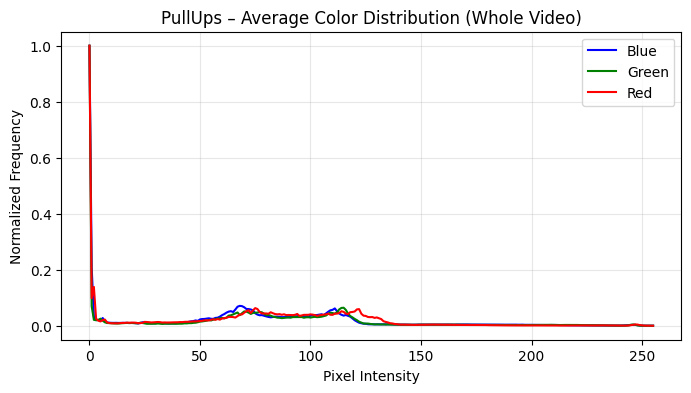

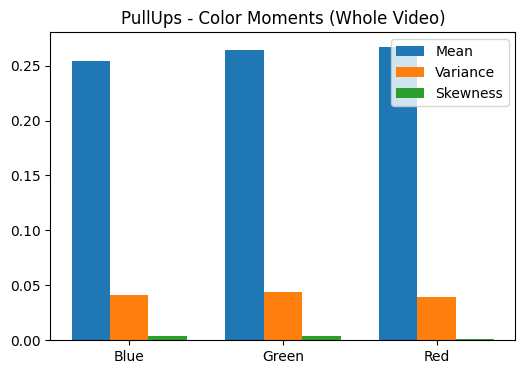


*****************************************
Class: Punch
Video: v_Punch_g19_c05.avi
*****************************************


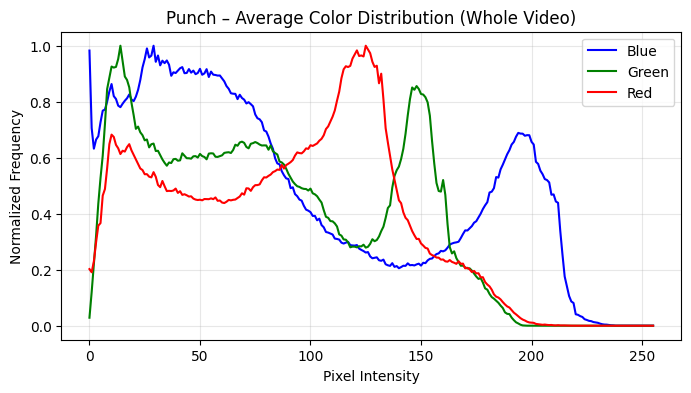

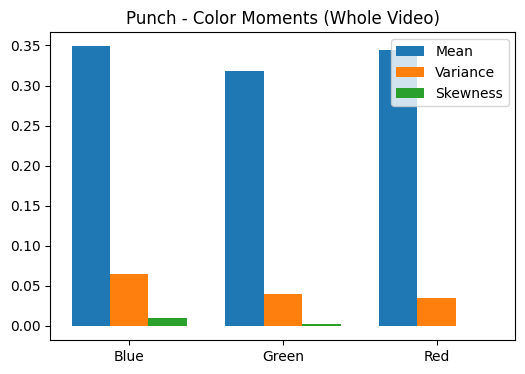


*****************************************
Class: PushUps
Video: v_PushUps_g23_c02.avi
*****************************************


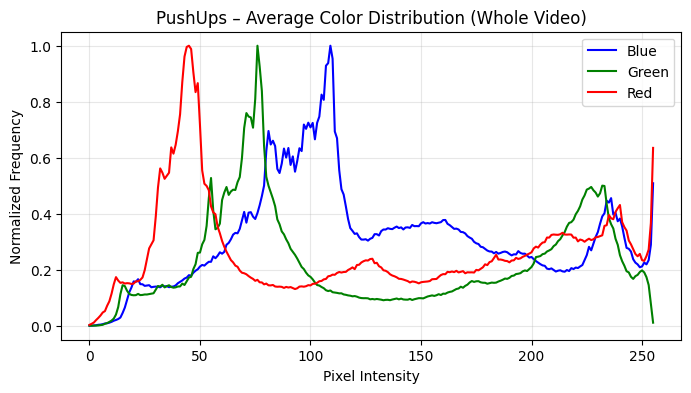

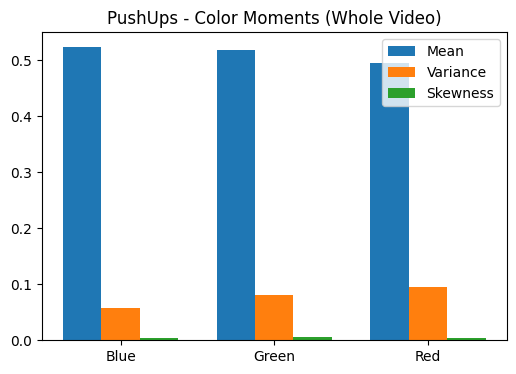

In [8]:
# ----------------------------------------------------------------------------
# 3. Average color distribution and Color moments for each video.
#    (Selected 1 video from each class.)
# ----------------------------------------------------------------------------

save_dir = "../results/feature_visualizations/color_features/avg_color_dist_and_color_moments";
os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    print("\n*****************************************")
    print("Class:", cls_name)
    print("Video:", os.path.basename(train_videos[idx]))
    print("*****************************************")

    frames = extract_frames(train_videos[idx])

    # ----------------------------------------------------------------------------
    # Average color distribution across video
    # ----------------------------------------------------------------------------

    avg_hist = np.zeros((3, 256), dtype=np.float64)

    for frame in frames:

        frame_uint8 = (frame * 255).astype(np.uint8)

        for c, col in enumerate(['b', 'g', 'r']):
            hist = cv2.calcHist(
                [frame_uint8],
                [c],
                None,
                [256],
                [0, 256]
            ).flatten()

            avg_hist[c] += hist

    # average over frames
    avg_hist /= len(frames)

    # normalize for visibility
    avg_hist /= avg_hist.max(axis=1, keepdims=True)

    # ---- Plot ----
    plt.figure(figsize=(8, 4))
    plt.plot(avg_hist[0], color='b', label='Blue')
    plt.plot(avg_hist[1], color='g', label='Green')
    plt.plot(avg_hist[2], color='r', label='Red')

    plt.title(f"{cls_name} – Average Color Distribution (Whole Video)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Normalized Frequency")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.savefig(
        f"{save_dir}/{cls_name}_average_color_distribution.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()
    plt.close()

    # ----------------------------------------------
    # 2. Color moments across video
    # ----------------------------------------------

    all_pixels = [];
    for frame in frames:
        all_pixels.append(frame.reshape(-1,3));

    all_pixels = np.concatenate(all_pixels, axis=0);

    mean = np.mean(all_pixels, axis=0);
    var  = np.var(all_pixels, axis=0);
    skew = np.mean((all_pixels - mean)**3, axis=0);

    labels = ['Blue','Green','Red'];
    x = np.arange(3);

    plt.figure(figsize=(6,4));
    plt.bar(x-0.25, mean, 0.25, label='Mean');
    plt.bar(x,      var,  0.25, label='Variance');
    plt.bar(x+0.25, skew, 0.25, label='Skewness');
    plt.xticks(x, labels);
    plt.title(f"{cls_name} - Color Moments (Whole Video)");
    plt.legend();
    plt.savefig(f"{save_dir}/{cls_name}_color_moments.png", dpi=300, bbox_inches="tight");
    plt.show();
    plt.close();


2. Texture features:

In [9]:
################################################################################################################
#............................................... Low-Level Features............................................#
################################################################################################################

# ...............................................  Texture features  ........................................... #

#------------------------------------------
# 1. Gray Level Co-occurrence Matrix (GLCM)
#------------------------------------------

# ===== save folder =====
save_dir = "../results/feature_visualizations/texture_features/glcm";
os.makedirs(save_dir, exist_ok=True);


for cls_name, idx in selected_indices.items():

    print("\n==============================")
    print("Generating GLCM for class:", cls_name)

    frames = extract_frames(train_videos[idx])
    num_frames = len(frames)

    for f in range(num_frames):

        frame = frames[f]

        # ---- convert to grayscale ----
        gray = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

        # ---- compute GLCM ----
        glcm = graycomatrix(
            gray,
            distances=[1],
            angles=[0],
            levels=256,
            symmetric=True,
            normed=True
        )

        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]

        labels = ["Contrast", "Homogeneity", "Energy", "Correlation"]
        values = [contrast, homogeneity, energy, correlation]

        # ---- plotting ----
        plt.figure(figsize=(8, 3))

        # left: grayscale frame
        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap="gray")
        plt.title(f"{cls_name} – Frame {f+1}", fontsize=8)
        plt.axis("off")

        # right: GLCM properties
        plt.subplot(1, 2, 2)
        plt.bar(labels, values)
        plt.yscale("log")  # ⭐ IMPORTANT
        plt.ylabel("Value (log scale)")
        plt.title("GLCM Texture Properties", fontsize=8)
        plt.grid(axis="y", alpha=0.3)

        plt.tight_layout()

        # ---- save single image per frame ----
        out_path = f"{save_dir}/{cls_name}_frame_{f+1:02d}_GLCM.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

print("\nAll GLCM visualizations saved at:", save_dir)

None;


Generating GLCM for class: PullUps

Generating GLCM for class: Punch

Generating GLCM for class: PushUps

All GLCM visualizations saved at: ../results/feature_visualizations/texture_features/glcm


In [10]:
#------------------------------------------
# 2. Local Binary Patterns (LBP)
#------------------------------------------

# ===== save folder =====
save_dir = "../results/feature_visualizations/texture_features/lbp";
os.makedirs(save_dir, exist_ok=True);

# LBP parameters
P = 8   # number of neighbors
R = 1   # radius

for cls_name, idx in selected_indices.items():

    print("\n==============================")
    print("Generating LBP for class:", cls_name)

    frames = extract_frames(train_videos[idx])
    num_frames = len(frames)

    for f in range(num_frames):

        frame = frames[f]

        # ---- convert to grayscale ----
        gray = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

        # ---- compute LBP ----
        lbp = local_binary_pattern(gray, P, R, method="uniform")

        # ---- plotting (single image per frame) ----
        plt.figure(figsize=(6, 3))

        # left: grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap="gray")
        plt.title(f"{cls_name} – Frame {f+1}", fontsize=8)
        plt.axis("off")

        # right: LBP texture map
        plt.subplot(1, 2, 2)
        plt.imshow(lbp, cmap="gray")
        plt.title("LBP Texture Map", fontsize=8)
        plt.axis("off")

        plt.tight_layout()

        # ---- save ----
        out_path = f"{save_dir}/{cls_name}_frame_{f+1:02d}_LBP.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

print("\nAll LBP visualizations saved at:", save_dir)

None;


Generating LBP for class: PullUps

Generating LBP for class: Punch

Generating LBP for class: PushUps

All LBP visualizations saved at: ../results/feature_visualizations/texture_features/lbp


In [11]:
#------------------------------------------
# 3. Gabor filter responses
#------------------------------------------


# ===== save folder =====
save_dir = "../results/feature_visualizations/texture_features/gabor";
os.makedirs(save_dir, exist_ok=True);

# Gabor parameters
frequency = 0.3;
for cls_name, idx in selected_indices.items():

    print("\n==============================")
    print("Generating Gabor for class:", cls_name)

    frames = extract_frames(train_videos[idx])

    for f, frame in enumerate(frames):

        gray = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

        real, imag = gabor(gray, frequency=frequency)

        # Gabor magnitude
        magnitude = np.sqrt(real**2 + imag**2)

        # Normalize for visualization
        
        mag_min = magnitude.min()
        mag_max = magnitude.max()

        if mag_max > mag_min:
            magnitude = (magnitude - mag_min) / (mag_max - mag_min)
        else:
            magnitude = np.zeros_like(magnitude)

        magnitude = (magnitude * 255).astype(np.uint8)


        plt.figure(figsize=(6,3))

        # left: grayscale image
        plt.subplot(1,2,1)
        plt.imshow(gray, cmap="gray")
        plt.title(f"{cls_name} – Frame {f+1}", fontsize=8)
        plt.axis("off")

        # Right: Gabor response image
        plt.subplot(1,2,2)
        plt.imshow(magnitude, cmap="gray")
        plt.title("Gabor Response", fontsize=8)
        plt.axis("off")

        plt.tight_layout()

        out_path = f"{save_dir}/{cls_name}_frame_{f+1:02d}_Gabor.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

print("\nAll Gabor images saved at:", save_dir)

None;


Generating Gabor for class: PullUps

Generating Gabor for class: Punch

Generating Gabor for class: PushUps

All Gabor images saved at: ../results/feature_visualizations/texture_features/gabor


3. Shape features

In [12]:
################################################################################################################
#............................................... Low-Level Features............................................#
################################################################################################################

# ...............................................  Shape features  ........................................... #


#-----------------------------------------------
# 1. Edge histograms using Canny edge detection
#-----------------------------------------------

# ===== save folder =====
save_dir = "../results/feature_visualizations/shape_features/canny_edges";
os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    print("\n==============================")
    print("Canny edge detection for class:", cls_name)

    frames = extract_frames(train_videos[idx])
    num_frames = len(frames)

    for f in range(num_frames):

        frame = frames[f]

        # ---- Convert to grayscale ----
        gray = cv2.cvtColor(
            (frame * 255).astype(np.uint8),
            cv2.COLOR_BGR2GRAY
        )

        # ---- Canny edge detection ----
        edges = cv2.Canny(gray, 100, 200)

        # ---- Plot single frame ----
        plt.figure(figsize=(8, 3))

        # left: grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap="gray")
        plt.title(f"{cls_name} – Frame {f+1}")
        plt.axis("off")

        # Right: Image with Canny edges
        plt.subplot(1, 2, 2)
        plt.imshow(edges, cmap="gray")
        plt.title("Canny Edges")
        plt.axis("off")

        plt.tight_layout()

        out_path = f"{save_dir}/{cls_name}_frame_{f+1:02d}_canny.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

print("\nAll Canny edge images saved at:", save_dir)

None;



Canny edge detection for class: PullUps

Canny edge detection for class: Punch

Canny edge detection for class: PushUps

All Canny edge images saved at: ../results/feature_visualizations/shape_features/canny_edges


In [13]:
#-----------------------------------------------
# 2. Contour-based features
#-----------------------------------------------

# ===== save folder =====
save_dir = "../results/feature_visualizations/shape_features/contours";
os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    print("\n==============================")
    print("Generating Contours for class:", cls_name)

    frames = extract_frames(train_videos[idx])
    num_frames = len(frames)

    for f in range(num_frames):

        frame = frames[f]

        # ---- Convert to grayscale ----
        gray = cv2.cvtColor(
            (frame * 255).astype(np.uint8),
            cv2.COLOR_BGR2GRAY
        )

        # ---- Preprocessing ----
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 80, 160)

        # ---- Find contours ----
        contours, _ = cv2.findContours(
            edges,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        # ---- Draw contours ----
        contour_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)

        # ---- Plot single frame ----
        plt.figure(figsize=(8, 3))

        # left: grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap="gray")
        plt.title(f"{cls_name} – Frame {f+1}")
        plt.axis("off")

        # Right: Image with contours
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
        plt.title("Contours")
        plt.axis("off")

        plt.tight_layout()

        out_path = f"{save_dir}/{cls_name}_frame_{f+1:02d}_contours.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

print("\nAll contour images saved at:", save_dir)

None;


Generating Contours for class: PullUps

Generating Contours for class: Punch

Generating Contours for class: PushUps

All contour images saved at: ../results/feature_visualizations/shape_features/contours


In [14]:
#-----------------------------------------------
# 3. HOG (Histogram of Oriented Gradients)
#-----------------------------------------------

# ===== save folder =====
save_dir = "../results/feature_visualizations/shape_features/hog";
os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    print("\n==============================")
    print("HOG for class:", cls_name)

    frames = extract_frames(train_videos[idx])
    num_frames = len(frames)

    for f in range(num_frames):

        frame = frames[f]

        # ---- Convert to grayscale ----
        gray = cv2.cvtColor(
            (frame * 255).astype(np.uint8),
            cv2.COLOR_BGR2GRAY
        )

        # ---- Compute HOG ----
        hog_features, hog_image = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            block_norm="L2-Hys"
        )

        # ---- Improve visibility of HOG image ----
        hog_image = exposure.rescale_intensity(hog_image, in_range=(0, np.max(hog_image)))

        # ---- Plot single frame ----
        plt.figure(figsize=(8, 3))

        # left: grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap="gray")
        plt.title(f"{cls_name} – Frame {f+1}")
        plt.axis("off")

        # Right: Image with HOG
        plt.subplot(1, 2, 2)
        plt.imshow(hog_image, cmap="gray")
        plt.title("HOG Visualization")
        plt.axis("off")

        plt.tight_layout()

        out_path = f"{save_dir}/{cls_name}_frame_{f+1:02d}_HOG.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()

print("\nAll HOG images saved at:", save_dir)

None;


HOG for class: PullUps

HOG for class: Punch

HOG for class: PushUps

All HOG images saved at: ../results/feature_visualizations/shape_features/hog


Motion Features:
1. Frame Differencing

In [15]:
################################################################################################################
#............................................... Motion Features............................................#
################################################################################################################

#-----------------------------------------------
# Frame Differencing
#-----------------------------------------------

# ===== save folder =====
save_dir = "../results/feature_visualizations/motion_features/frame_differencing";
os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    print("\n==============================")
    print("Frame differencing for class:", cls_name)

    frames = extract_frames(train_videos[idx])
    num_frames = len(frames)

    for f in range(1, num_frames):

        # ---- Convert frames to grayscale ----
        prev = cv2.cvtColor(
            (frames[f-1] * 255).astype(np.uint8),
            cv2.COLOR_BGR2GRAY
        )
        curr = cv2.cvtColor(
            (frames[f] * 255).astype(np.uint8),
            cv2.COLOR_BGR2GRAY
        )

        # ---- Absolute frame difference ----
        diff = cv2.absdiff(curr, prev)

        # ---- Statistics (original diff) ----
        mean_diff = np.mean(diff)
        std_diff  = np.std(diff)

        # ---- Visualization enhancement (ONLY for plotting) ----
        diff_vis = cv2.normalize(
            diff, None, 0, 255, cv2.NORM_MINMAX
        ).astype(np.uint8)

        # ---- Plot (single image per frame) ----
        plt.figure(figsize=(10, 3))

        # left: grayscale image
        plt.subplot(1, 3, 1)
        plt.imshow(curr, cmap="gray")
        plt.title(f"{cls_name} – Frame {f+1}")
        plt.axis("off")

        # Middle: Enhanced frame difference (visual)
        plt.subplot(1, 3, 2)
        plt.imshow(diff_vis, cmap="inferno")   
        plt.title("Frame Difference")
        plt.axis("off")

        # Right: Histogram (log scale)
        plt.subplot(1, 3, 3)
        hist = cv2.calcHist([diff], [0], None, [256], [0, 256])
        plt.plot(hist, color="black")
        plt.yscale("log")                   
        plt.title(f"Mean={mean_diff:.1f}, Std={std_diff:.1f}")
        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()


        out_path = f"{save_dir}/{cls_name}_frame_{f:02d}_diff.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()
    
print("\nAll frame differencing results saved at:", save_dir)

None;


Frame differencing for class: PullUps

Frame differencing for class: Punch

Frame differencing for class: PushUps

All frame differencing results saved at: ../results/feature_visualizations/motion_features/frame_differencing


2. Optical Flow
- Lucas-Kanade sparse optical flow

In [16]:
#-----------------------------------------------
# 1. Lucas-Kanade sparse optical flow
#-----------------------------------------------

# ===== save folder =====
save_dir = "../results/feature_visualizations/motion_features/optical_flow/lukas-kanade";
os.makedirs(save_dir, exist_ok=True);

# Shi-Tomasi corner detection parameters (To detect the motion points.)
feature_params = dict(maxCorners=200,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7);

# Lucas-Kanade optical flow parameters (To check the direction of the motion)
lk_params = dict(winSize=(15,15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03));


for cls_name, idx in selected_indices.items():

    print("\n==============================")
    print("Calculated Lucas-Kanade optical flow for:", cls_name)
    print("==============================")

    frames = extract_frames(train_videos[idx])
    num_frames = len(frames)

    # ---- first frame ----
    old_gray = cv2.cvtColor(
        (frames[0] * 255).astype(np.uint8),
        cv2.COLOR_BGR2GRAY
    )

    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    if p0 is None:
        print("⚠ No features detected in first frame, skipping:", cls_name)
        continue

    for f in range(1, num_frames):

        frame = frames[f]
        frame_gray = cv2.cvtColor(
            (frame * 255).astype(np.uint8),
            cv2.COLOR_BGR2GRAY
        )

        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_gray, frame_gray, p0, None, **lk_params
        )

        vis = (frame * 255).astype(np.uint8).copy()

        if p1 is not None and st is not None:

            good_new = p1[st == 1]
            good_old = p0[st == 1]

            for (new, old) in zip(good_new, good_old):

                a, b = new.ravel()
                c, d = old.ravel()

                # ---- motion magnitude ----
                mag = np.sqrt((a - c)**2 + (b - d)**2)

                # skip very small motion (noise)
                if mag < 1.0:
                    continue

                # exaggerate motion for visibility
                scale = 3
                ax = int(c + scale * (a - c))
                ay = int(d + scale * (b - d))

                # color based on motion strength
                color = (0, min(255, int(mag * 15)), 255)

                cv2.arrowedLine(
                    vis,
                    (int(c), int(d)),
                    (ax, ay),
                    color,
                    2,
                    tipLength=0.25
                )

                cv2.circle(vis, (int(a), int(b)), 2, (0, 0, 255), -1)

            # update points
            p0 = good_new.reshape(-1, 1, 2)

        else:
            # re-detect features if tracking fails
            p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)

        # ---- overlay info ----
        cv2.putText(
            vis,
            f"{cls_name} | Frame {f}/{num_frames}",
            (10, 25),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (255, 255, 255),
            2
        )

        # ---- save frame ----
        out_path = f"{save_dir}/{cls_name}_frame_{f:02d}.png"
        cv2.imwrite(out_path, cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))

        old_gray = frame_gray.copy()

print("\nResults saved at:", save_dir)

None;


Calculated Lucas-Kanade optical flow for: PullUps

Calculated Lucas-Kanade optical flow for: Punch

Calculated Lucas-Kanade optical flow for: PushUps

Results saved at: ../results/feature_visualizations/motion_features/optical_flow/lukas-kanade


- Horn-Schunck dense optical flow

In [17]:
#-----------------------------------------------
# 2. Horn-Schunck dense optical flow
#-----------------------------------------------

save_dir = "../results/feature_visualizations/motion_features/optical_flow/Horn-Schunck";
os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    print("\nGenerated dense optical flow for:", cls_name);

    frames = extract_frames(train_videos[idx]);
    num_frames = len(frames);

    prev_gray = cv2.cvtColor((frames[0] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

    #fig = plt.figure(figsize=(18, (num_frames-1) * 4));

    for f in range(1, num_frames):
        curr_gray = cv2.cvtColor(
            (frames[f] * 255).astype(np.uint8),
            cv2.COLOR_BGR2GRAY
        )

        # ---- Dense optical flow (Farnebäck) ----
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, curr_gray,
            None, 0.5, 3, 15, 3, 5, 1.2, 0
        )

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

        # ---- Magnitude map ----
        mag_norm = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        mag_norm = mag_norm.astype(np.uint8)
        mag_color = cv2.applyColorMap(mag_norm, cv2.COLORMAP_INFERNO)

        # ---- Direction map (HSV → RGB) ----
        hsv = np.zeros((curr_gray.shape[0], curr_gray.shape[1], 3), dtype=np.uint8)
        hsv[...,1] = 255
        hsv[...,0] = ang * 180 / np.pi / 2
        hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        # ---- Gray frame to 3-channel ----
        gray_rgb = cv2.cvtColor(curr_gray, cv2.COLOR_GRAY2RGB)

        # ---- Combine all three (side-by-side) ----
        combined = np.hstack([gray_rgb, mag_color, flow_rgb])

        # ---- Save per-frame image ----
        out_path = f"{save_dir}/{cls_name}_frame_{f:02d}.png"
        cv2.imwrite(out_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))

        prev_gray = curr_gray.copy()
        
print("\nResults saved at:", save_dir)

None;


Generated dense optical flow for: PullUps

Generated dense optical flow for: Punch

Generated dense optical flow for: PushUps

Results saved at: ../results/feature_visualizations/motion_features/optical_flow/Horn-Schunck


- Motion magnitude and direction histograms
- Average motion intensity and dominant direction


Motion stats for: PullUps
Average motion intensity: 0.9146236
Dominant direction (radians): 3.0426617


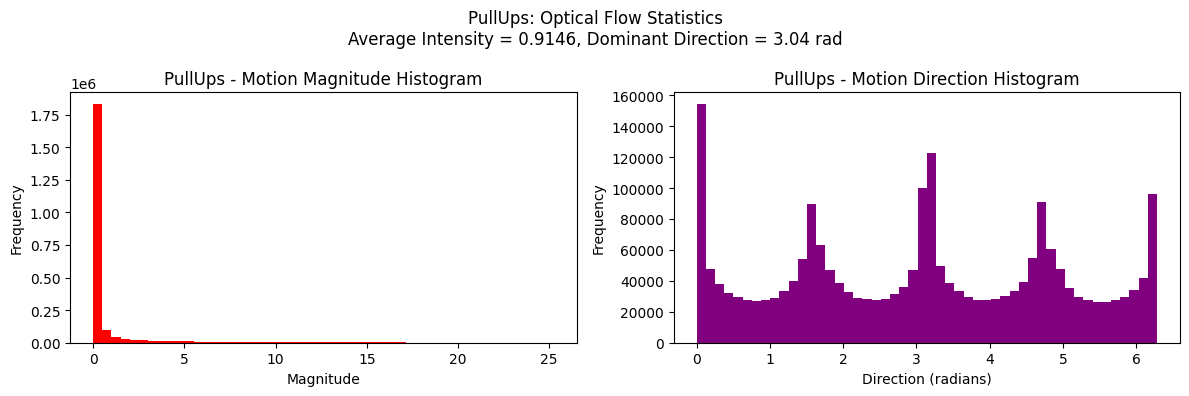


Motion stats for: Punch
Average motion intensity: 9.08187
Dominant direction (radians): 3.3610337


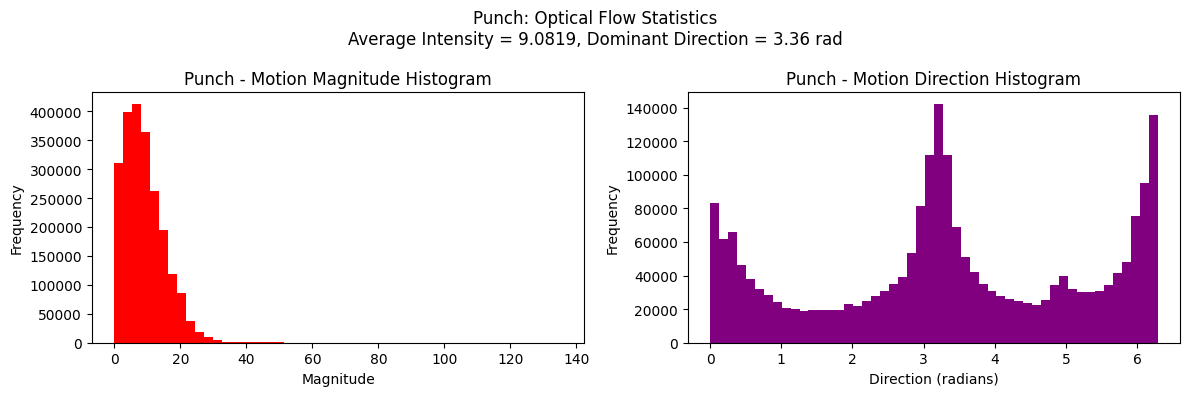


Motion stats for: PushUps
Average motion intensity: 3.667272
Dominant direction (radians): 3.1566763


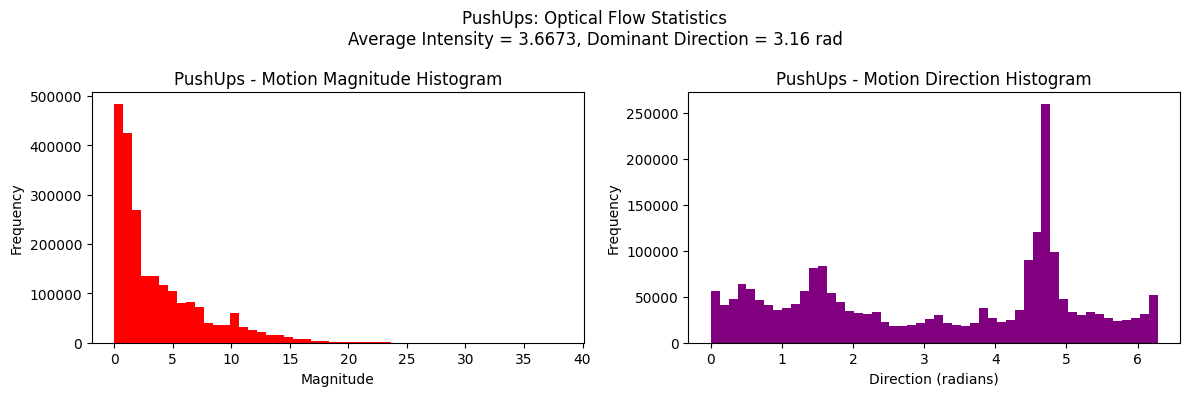

In [18]:
#-----------------------------------------------
# Motion magnitude and direction histograms
# Average motion intensity and dominant direction`
#-----------------------------------------------

save_dir = "../results/feature_visualizations/motion_features/optical_flow/statistics";
os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    print("\nMotion stats for:", cls_name);

    frames = extract_frames(train_videos[idx]);
    num_frames = len(frames);

    all_mags = [];
    all_angs = [];

    prev_gray = cv2.cvtColor((frames[0] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)


    for f in range(1, num_frames):
        curr_gray = cv2.cvtColor((frames[f] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)


        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0);

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1]);

        all_mags.append(mag.flatten());
        all_angs.append(ang.flatten());

        prev_gray = curr_gray.copy();

    all_mags = np.concatenate(all_mags);
    all_angs = np.concatenate(all_angs);

    # ---- statistics ----
    avg_motion = np.mean(all_mags);
    dominant_direction = np.mean(all_angs);

    print("Average motion intensity:", avg_motion);
    print("Dominant direction (radians):", dominant_direction);

    # ---- plots ----
    plt.figure(figsize=(12,4));

    plt.subplot(1,2,1);
    plt.hist(all_mags, bins=50, color="red");
    plt.title(f"{cls_name} - Motion Magnitude Histogram");
    plt.xlabel("Magnitude");
    plt.ylabel("Frequency");

    plt.subplot(1,2,2);
    plt.hist(all_angs, bins=50, color="purple");
    plt.title(f"{cls_name} - Motion Direction Histogram");
    plt.xlabel("Direction (radians)");
    plt.ylabel("Frequency");

    plt.suptitle(f"{cls_name}: Optical Flow Statistics\n"
                 f"Average Intensity = {avg_motion:.4f}, "
                 f"Dominant Direction = {dominant_direction:.2f} rad");

    plt.tight_layout();
    plt.savefig(f"{save_dir}/{cls_name}_MotionStats.png", dpi=300);
    plt.show();
    plt.close();


3. Motion History Images (MHI)


MHI for: PullUps
Motion energy: 12789


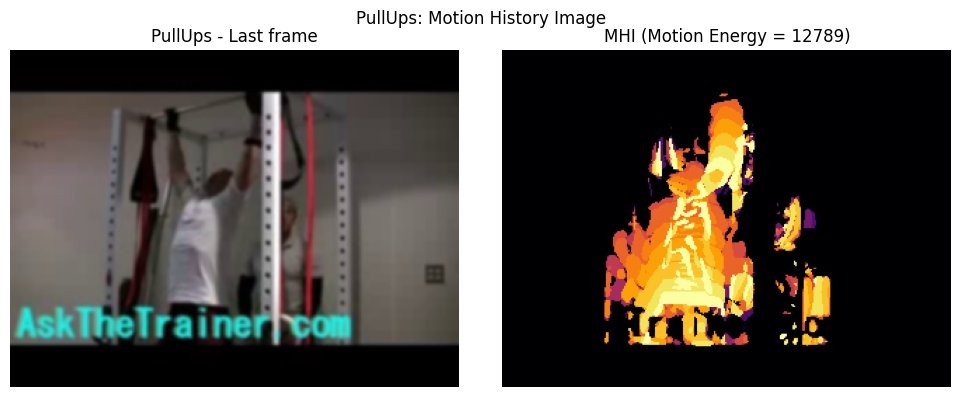


MHI for: Punch
Motion energy: 76688


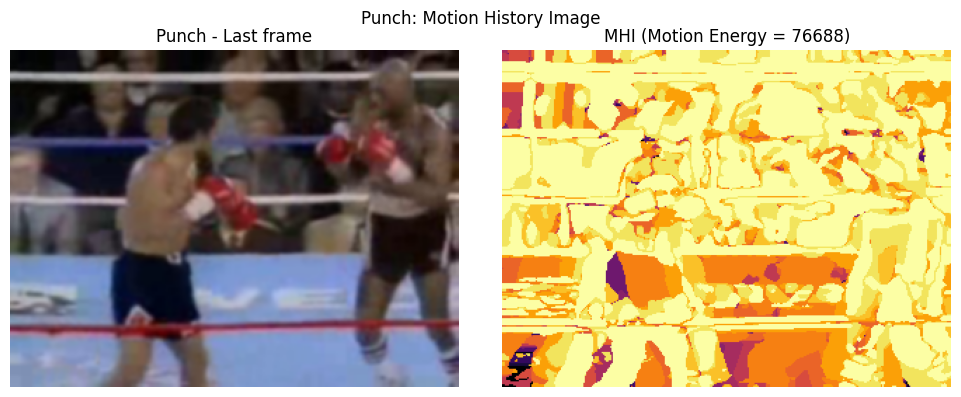


MHI for: PushUps
Motion energy: 73761


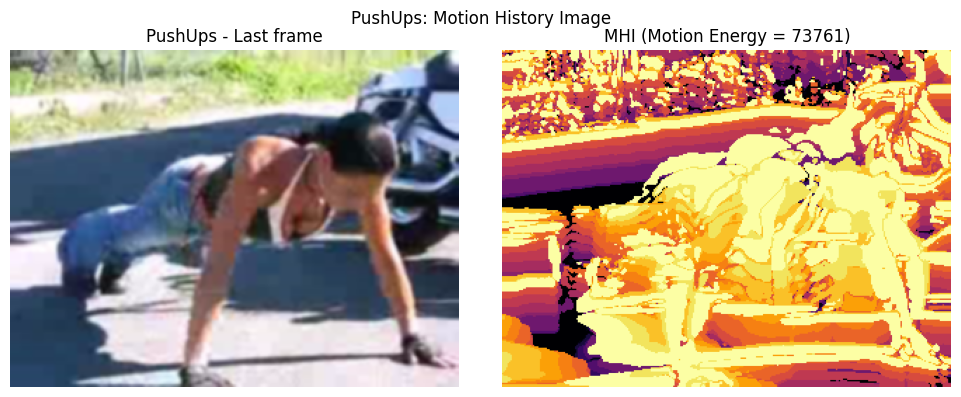

In [19]:
#-----------------------------------------------
# Motion History Images (MHI)
# Temporal template creation
# Motion energy analysis
#-----------------------------------------------

save_dir = "../results/feature_visualizations/motion_features/mhi";
os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    print("\nMHI for:", cls_name);

    frames = extract_frames(train_videos[idx]);
    num_frames = len(frames);

    h, w, _ = frames[0].shape;
    mhi = np.zeros((h, w), dtype=np.float32);

    #prev_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY);
    prev_gray = cv2.cvtColor((frames[0] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    timestamp = 1;
    decay = 30;   #motion stay duration

    for f in range(1, num_frames):
        #curr_gray = cv2.cvtColor(frames[f], cv2.COLOR_BGR2GRAY);
        curr_gray = cv2.cvtColor((frames[f] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

        diff = cv2.absdiff(curr_gray, prev_gray);
        _, motion_mask = cv2.threshold(diff, 25, 1, cv2.THRESH_BINARY);

        # update MHI
        mhi[motion_mask == 1] = timestamp;
        mhi[motion_mask == 0] -= 1;
        mhi[mhi < 0] = 0;

        prev_gray = curr_gray.copy();
        timestamp += 1;

    # normalize for display
    mhi_norm = cv2.normalize(mhi, None, 0, 255, cv2.NORM_MINMAX);
    mhi_norm = mhi_norm.astype(np.uint8);

    # ---- motion energy ----
    motion_energy = np.sum(mhi_norm > 0);

    print("Motion energy:", motion_energy);

    # ---- plots ----
    plt.figure(figsize=(10,4));

    plt.subplot(1,2,1);
    #plt.imshow(cv2.cvtColor(frames[-1], cv2.COLOR_BGR2RGB));
    last_vis = (frames[-1] * 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(last_vis, cv2.COLOR_BGR2RGB))

    plt.title(f"{cls_name} - Last frame");
    plt.axis("off");

    plt.subplot(1,2,2)
    plt.imshow(mhi_norm, cmap="inferno");
    plt.title(f"MHI (Motion Energy = {motion_energy})");
    plt.axis("off");

    plt.suptitle(f"{cls_name}: Motion History Image");
    plt.tight_layout();

    plt.savefig(f"{save_dir}/{cls_name}_MHI.png", dpi=300);
    plt.show();
    plt.close();

Temporal Features
- Statistical measures of feature sequences (mean, std, min, max)
- Frame-to-frame variation analysis
- Temporal gradients and patterns


Temporal features for: PullUps
Mean: 0.9146235 Std: 0.39698395 Min: 0.20559452 Max: 1.8525388


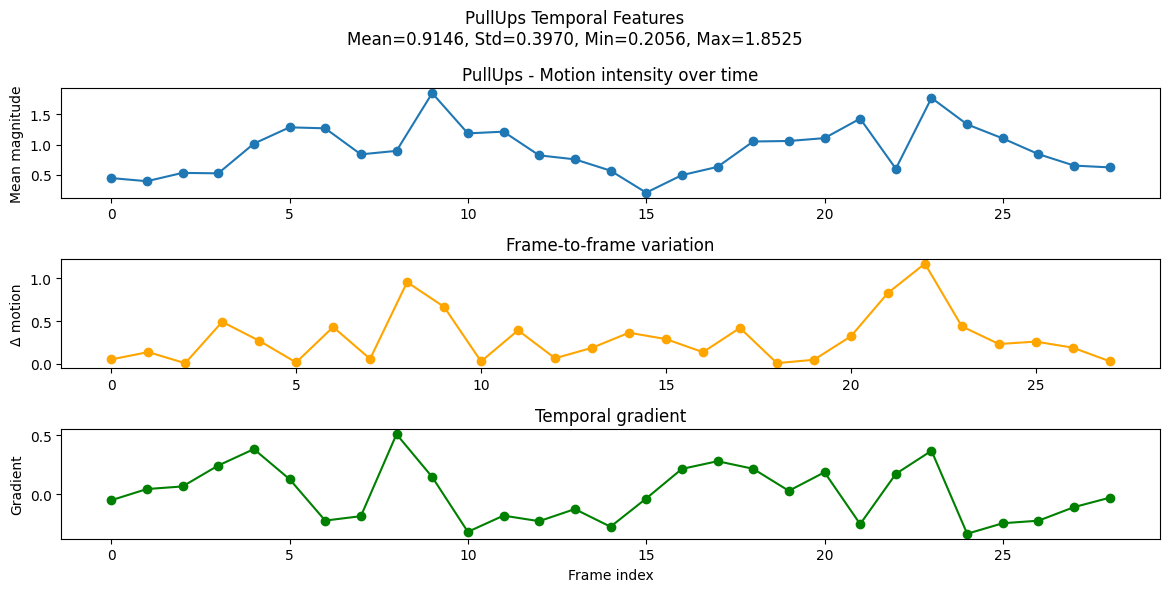


Temporal features for: Punch
Mean: 9.08187 Std: 1.4202224 Min: 5.1275473 Max: 11.685384


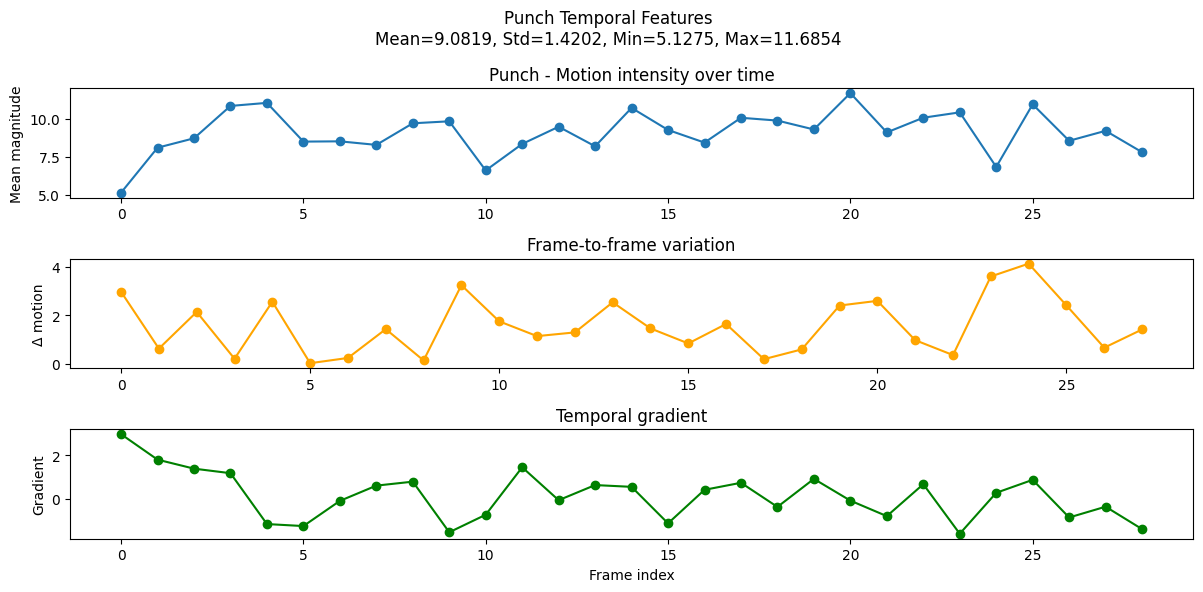


Temporal features for: PushUps
Mean: 3.6672719 Std: 1.5906999 Min: 1.2547493 Max: 9.115503


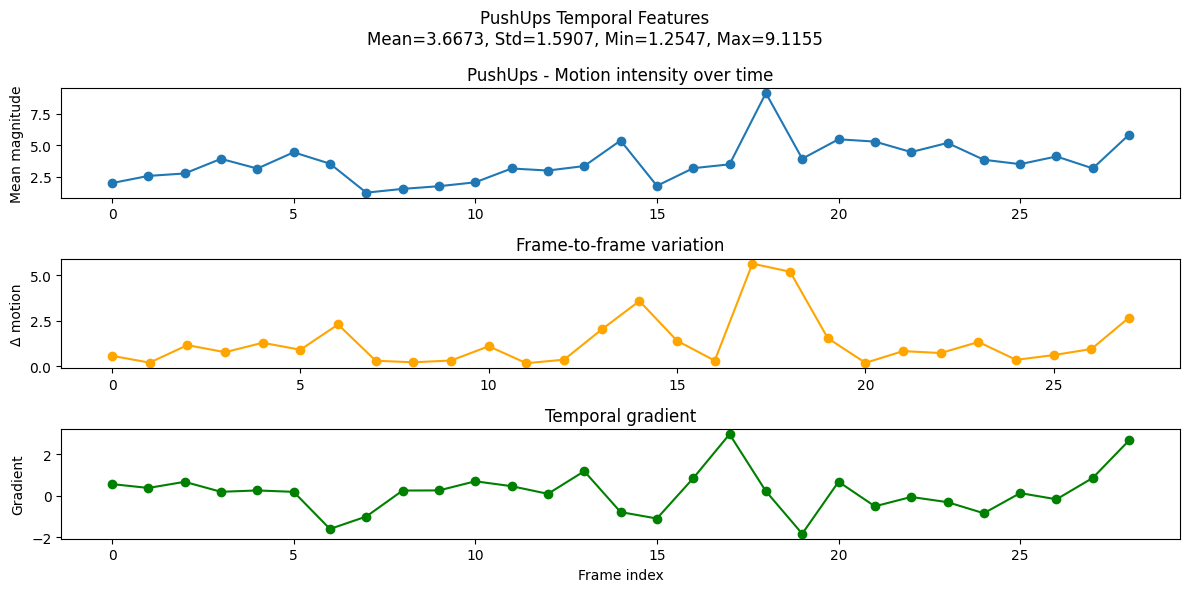

In [20]:
################################################################################################################
#............................................... Temporal Features............................................#
################################################################################################################

#-----------------------------------------------
# Statistical measures of feature sequences (mean, std, min, max)
# Frame-to-frame variation analysis
# Temporal gradients and patterns
#-----------------------------------------------


save_dir = "../results/feature_visualizations/temporal_features";
os.makedirs(save_dir, exist_ok=True);

for cls_name, idx in selected_indices.items():

    print("\nTemporal features for:", cls_name);

    frames = extract_frames(train_videos[idx]);
    num_frames = len(frames);

    #prev_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY);
    prev_gray = cv2.cvtColor((frames[0] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY);

    motion_series = [];

    # ---- creating temporal motion sequence ----
    for f in range(1, num_frames):
        curr_gray = cv2.cvtColor(frames[f], cv2.COLOR_BGR2GRAY);
        curr_gray = cv2.cvtColor((frames[f] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY);

        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0);

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1]);
        motion_series.append(np.mean(mag));

        prev_gray = curr_gray.copy();

    motion_series = np.array(motion_series);

    # ---- statistical measures ----
    mean_val = np.mean(motion_series);
    std_val  = np.std(motion_series);
    min_val  = np.min(motion_series);
    max_val  = np.max(motion_series);

    # ---- checking frame-to-frame variation ----
    variation = np.abs(np.diff(motion_series));

    # ---- calculating temporal gradient ----
    gradient = np.gradient(motion_series);

    print("Mean:", mean_val, "Std:", std_val, "Min:", min_val, "Max:", max_val);

    # ---- creating plots ----
    plt.figure(figsize=(12,6));

    plt.subplot(3,1,1);
    plt.plot(motion_series, marker="o");
    plt.title(f"{cls_name} - Motion intensity over time");
    plt.ylabel("Mean magnitude");

    plt.subplot(3,1,2);
    plt.plot(variation, color="orange", marker="o");
    plt.title("Frame-to-frame variation");
    plt.ylabel("Δ motion");

    plt.subplot(3,1,3);
    plt.plot(gradient, color="green", marker="o");
    plt.title("Temporal gradient");
    plt.xlabel("Frame index");
    plt.ylabel("Gradient");

    plt.suptitle(
        f"{cls_name} Temporal Features\n"
        f"Mean={mean_val:.4f}, Std={std_val:.4f}, Min={min_val:.4f}, Max={max_val:.4f}"
    );

    plt.tight_layout();
    plt.savefig(f"{save_dir}/{cls_name}_TemporalFeatures.png", dpi=300);
    plt.show();
    plt.close();


### Extracting all features and building feature matrix for Model Training
- This section will take around 15 minutes to complete.
- Here, features are extracted from 362 videos.
- Train dataset: 271 videos
- Test dataset: 46 videos
- Validation dataset: 45 videos 

In [21]:
# Function for extracting all the features from all the videos in the dataset.
# The extract_all_features Function is using the other functions defined in feature_extraction.py file
# It is extracting 4 types of features:
# 1. Color Features
# 2. Texture Features
# 3. Shape Features
# 4. Motion Features

def extract_all_features(frames):
    feat_color   = video_color_features(frames);
    feat_texture = video_texture_features(frames);
    feat_shape   = video_shape_features(frames);
    feat_motion  = temporal_motion_features(frames);

    return np.hstack([feat_color, feat_texture, feat_shape, feat_motion]);


# Function for creating the feature matrix.
#tqdm shows the progress bar for better visualization.

def build_feature_matrix(video_list, labels):
    X, y = [], [] 

    for i in tqdm(range(len(video_list))):
        frames = extract_frames(video_list[i]);
        features = extract_all_features(frames);
        X.append(features);
        y.append(labels[i]);

    return np.array(X), np.array(y);

#Variable Representations:
# 1. X_train = [video1_features, video2_features, ...]: Represents Feature matrix
# 2. shape: (num_videos, num_features) 
# 3. y_train = class labels (0,1,2) Represents output vector

print("Building feature matrix for train dataset:");
X_train, y_train = build_feature_matrix(train_videos, train_labels);

print("\nBuilding feature matrix for test dataset:");
X_test, y_test   = build_feature_matrix(test_videos, test_labels);

print("\nBuilding feature matrix for validation dataset:");
X_val, y_val     = build_feature_matrix(val_videos, val_labels);


print("\nPrinting dataset shape: (Number of videos, number of features extracted)\n");
print("Train:", X_train.shape);
print("Test: ", X_test.shape);
print("Validation:  ", X_val.shape);


# ===================================================
# Feature Quality Enhancement.
# Handling missing / invalid feature values
# NaN (Not a Number)
# +Inf (Nositive infinity)
# -Inf (Negative infinity)
# ===================================================

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0);
X_test  = np.nan_to_num(X_test,  nan=0.0, posinf=0.0, neginf=0.0);
X_val   = np.nan_to_num(X_val,   nan=0.0, posinf=0.0, neginf=0.0);

print("\nNaN and Inf values (if any) have been handled in all feature matrices.");


# Saving the built feature matrices:

np.save("../results/saved_feature_matrices/X_train.npy", X_train);
np.save("../results/saved_feature_matrices/X_val.npy", X_val);
np.save("../results/saved_feature_matrices/X_test.npy", X_test);

np.save("../results/saved_feature_matrices/y_train.npy", y_train);
np.save("../results/saved_feature_matrices/y_val.npy", y_val);
np.save("../results/saved_feature_matrices/y_test.npy", y_test);

Building feature matrix for train dataset:


100%|██████████| 271/271 [10:16<00:00,  2.27s/it]



Building feature matrix for test dataset:


100%|██████████| 46/46 [01:41<00:00,  2.20s/it]



Building feature matrix for validation dataset:


100%|██████████| 45/45 [01:33<00:00,  2.09s/it]



Printing dataset shape: (Number of videos, number of features extracted)

Train: (271, 75173)
Test:  (46, 75173)
Validation:   (45, 75173)

NaN and Inf values (if any) have been handled in all feature matrices.


### Classical Machine Learning Algorithms

Implementing following Classical Machine Learning Models
- Support Vector Machines (SVM)
- Random Forest
- k-Nearest Neighbors (k-NN)
- Logistic Regression
- Gradient Boosting (XGBoost or LightGBM)



------------------------------------------------------------------------

1. Support Vector Machines (SVM)
- Linear and RBF kernels
- Hyperparameter tuning using cross-validation

In [22]:
# ===================================================
# Feature normalization for distance-based models
# (Required for SVM, Logistic Regression, KNN)
# ===================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

#Creating pipeline:
# Support Vector Machine (Linear Kernel):

linear_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", probability=True, random_state=42))
]);

#Creating pipeline:
# Support Vector Machine (RBF Kernel):

rbf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", gamma="scale", probability=True, random_state=42))
]);

#Training the models:
# Linear SVM:
linear_svm.fit(X_train, y_train);

# Linear SVM:
rbf_svm.fit(X_train, y_train);

# Collecting the predicted outputs:
pred_lin = linear_svm.predict(X_val);
pred_rbf = rbf_svm.predict(X_val);

# Validation check: (Linear SVM)
print("Linear SVM (VAL):", accuracy_score(y_val, pred_lin));
print(classification_report(y_val, pred_lin));

# Validation check: (RBF SVM)
print("RBF SVM (VAL):", accuracy_score(y_val, pred_rbf));
print(classification_report(y_val, pred_rbf));


Linear SVM (VAL): 0.9777777777777777
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.95      0.97        20
           2       1.00      1.00      1.00        13

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

RBF SVM (VAL): 0.8888888888888888
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.83      1.00      0.91        20
           2       1.00      0.69      0.82        13

    accuracy                           0.89        45
   macro avg       0.92      0.87      0.88        45
weighted avg       0.90      0.89      0.88        45



SVM: Hyperparameter Tuning
- This section will take around 5 minutes to complete.

In [23]:
# Goal is to automatically find the best SVM configuration instead of choosing parameters manually.
# SVM performance depends heavily on hyperparameters, mainly:
# C → controls margin softness (regularization)
# gamma → controls how flexible the RBF decision boundary is
# Wrong values can cause:
# Underfitting (model too simple)
# Overfitting (model too complex)
# So we systematically search for the best combination.


#This defines the search space of hyperparameters.
param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", 0.01]
};
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, random_state=42))
])


# Try all combinations of C and gamma
# For each combination:
# Split training data into 5 folds
# Train on 4 folds, validate on 1 fold
# Repeat 5 times
# Take average accuracy
# Use parallel CPU cores to speed up
# So instead of trusting one split, the model is evaluated on multiple internal validations, making the selection reliable.

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=4, 
    verbose=2
);

# At this point, the system:
# Trains many SVMs
# Evaluates them using 5-fold cross-validation
# Selects the configuration that gives the highest mean validation accuracy

grid.fit(X_train, y_train);

print("Best Params:", grid.best_params_);
print("Best CV Accuracy:", grid.best_score_);

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params: {'svm__C': 10, 'svm__gamma': 'scale'}
Best CV Accuracy: 0.8228327228327229


Getting the best SVM:

In [24]:
# This section gives the best SVM:
# Now best_svm is the tuned SVM model.ValueError
# Already trained on the full training set with the optimal hyperparameters.
best_svm = grid.best_estimator_;

# The tuned SVM is applied to the separate validation set
# These samples were not used for fitting the model parameters

val_pred = best_svm.predict(X_val);

#This evaluates:
# Overall accuracy
# Per-class precision, recall, and F1-score
# Here we can check:
#      - Which actions are well recognized.
#      - Which actions are being confused.
#      - Whether tuning actually improved generalization.

print("Tuned SVM (VAL):", accuracy_score(y_val, val_pred));
print(classification_report(y_val, val_pred));


Tuned SVM (VAL): 0.9111111111111111
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.83      1.00      0.91        20
           2       1.00      0.77      0.87        13

    accuracy                           0.91        45
   macro avg       0.94      0.90      0.91        45
weighted avg       0.93      0.91      0.91        45



SVM - Final report:

Final Test Accuracy: 0.9130434782608695
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.83      1.00      0.91        20
           2       1.00      0.77      0.87        13

    accuracy                           0.91        46
   macro avg       0.94      0.90      0.91        46
weighted avg       0.93      0.91      0.91        46



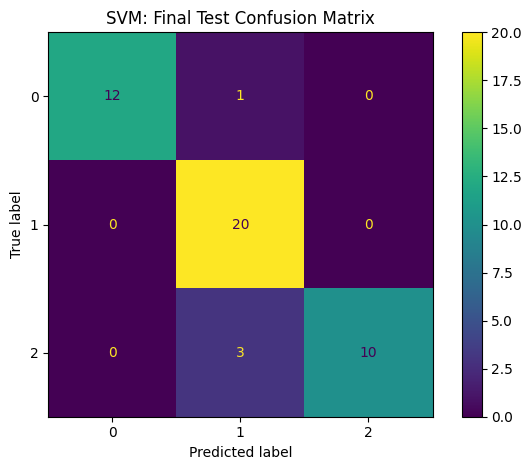

In [25]:
# FINAL STAGE: Train on Full Development Set & Test on Unseen Data
# This block is responsible for producing the final reported results.

# 1. Merging Training and Validation Sets

    # vstack → vertically stacks feature matrices
    # hstack → joins label vectors
    # Therefor now:
        # X_final contains all samples from both training and validation sets
        # y_final contains their corresponding labels

X_final = np.vstack([X_train, X_val]);
y_final = np.hstack([y_train, y_val]);

# 2. Final Model Training
    # This trains the tuned SVM model from scratch using:
        # Optimal hyperparameters (from GridSearch)
        # The full development dataset (train + validation)
    # This gives final production model.

start = time.perf_counter()
best_svm.fit(X_final, y_final)
svm_train_time = time.perf_counter() - start

# 3. Prediction on Test Set (True Unseen Data)
# The test set is:
    # Never used in training
    # Never used in hyperparameter tuning
    # Never used in validation
# So this step measures true generalization performance.

start = time.perf_counter()
svm_test_pred = best_svm.predict(X_test)
svm_test_time = time.perf_counter() - start

# 4. Final Performance Metric
# This outputs:
    # Overall accuracy
    # Precision per class
    # Recall per class
    # F1-score per class

print("Final Test Accuracy:", accuracy_score(y_test, svm_test_pred));
print(classification_report(y_test, svm_test_pred));

# 5. Confusion Matrix Visualization
# This visualizes:
    # Correct predictions (diagonal)
    # Misclassifications (off-diagonal)
# It helps analyze:
    # Which actions are confused
    # Which actions are most reliably recognized
# This is critical for:
    # discussion section
    # comparative analysis
    # error analysis

save_path = "../results/confusion_matrices/classical/svm_confusion_matrix.png";

disp = ConfusionMatrixDisplay.from_predictions(y_test, svm_test_pred);
plt.title("SVM: Final Test Confusion Matrix");
plt.tight_layout();
plt.savefig(save_path, dpi=300);
plt.show();
plt.close();



np.save("../results/stats_classical/svm_train_time.npy", svm_train_time);
np.save("../results/stats_classical/svm_test_time.npy", svm_test_time);

svm_acc = accuracy_score(y_test, svm_test_pred);
svm_f1  = f1_score(y_test, svm_test_pred, average="macro");

np.save("../results/stats_classical/svm_accuracy.npy", svm_acc);
np.save("../results/stats_classical/svm_f1.npy", svm_f1);




SVM: Error Analysis – Identify failure cases

In [26]:
# Find indices where the model prediction is wrong i.e., predicted label is not equal to true label.
wrong_idx = np.where(y_test != svm_test_pred)[0];

# Print total number of misclassified test samples
print("\nNumber of misclassified test videos:", len(wrong_idx));

# Display details of a few wrong predictions (first 5 only)
# This helps in manually inspecting failure cases
for i in wrong_idx:

    # Print the video file path
    print("Video:", test_videos[i]);

    # Print the true class label and the model's predicted label
    print("True Label:", y_test[i], "Predicted Label:", svm_test_pred[i]);

    # Print a separator line for better readability
    print("-" * 50);


Number of misclassified test videos: 4
Video: ../dataset_info/dataset\PullUps/v_PullUps_g06_c04.avi
True Label: 0 Predicted Label: 1
--------------------------------------------------
Video: ../dataset_info/dataset\PushUps/v_PushUps_g07_c04.avi
True Label: 2 Predicted Label: 1
--------------------------------------------------
Video: ../dataset_info/dataset\PushUps/v_PushUps_g07_c01.avi
True Label: 2 Predicted Label: 1
--------------------------------------------------
Video: ../dataset_info/dataset\PushUps/v_PushUps_g16_c03.avi
True Label: 2 Predicted Label: 1
--------------------------------------------------


2. Random Forest
   - Feature importance analysis
   - Tree depth and ensemble size optimization

In [27]:

# Implementing PCA (Principle Component Analysis):
pca = PCA(n_components=0.95, random_state=42);

X_train_pca = pca.fit_transform(X_train);
X_val_pca   = pca.transform(X_val);
X_test_pca_rf  = pca.transform(X_test);

print("Original feature dimension:", X_train.shape[1]);
print("Reduced feature dimension:", X_train_pca.shape[1]);

print(np.cumsum(pca.explained_variance_ratio_));


# Baseline Random Forest
    # This creates a basic Random Forest model.
# n_estimators=100
    # → builds 100 decision trees
# max_depth=8 → trees are allowed to grow only till level 8
# random_state=42 → makes results reproducible
# n_jobs=28 → uses 28 CPU cores in parallel

rf_base = RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=28
)

# Train all trees using the training data.
# Each tree:
    # Sees a random subset of samples
    # Sees a random subset of features
    # This randomness reduces overfitting.

rf_base.fit(X_train_pca, y_train);

# Predicts class labels for validation videos.
val_pred_base = rf_base.predict(X_val_pca);


# Evaluate how well the baseline forest generalizes.
# This gives a reference before tuning.
print("\nBaseline RF Validation Accuracy:", accuracy_score(y_val, val_pred_base));
print(classification_report(y_val, val_pred_base));


Original feature dimension: 75173
Reduced feature dimension: 3
[0.74858975 0.94014371 0.99019766]

Baseline RF Validation Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.94      0.85      0.89        20
           2       0.77      0.77      0.77        13

    accuracy                           0.87        45
   macro avg       0.86      0.87      0.86        45
weighted avg       0.87      0.87      0.87        45



Random Forest:

Hyperparameter tuning. 
 - (Tree depth & number of trees)

In [28]:
# param_grid defines the hyperparameter search space.
# n_estimators → number of trees
# max_depth → maximum depth of each tree
# min_samples_split → minimum samples needed to split a node
# min_samples_leaf → minimum samples required at a leaf
# These control:
    # model complexity
    # overfitting vs generalization

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 8, 12],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4]
}


# Creates a fresh Random Forest model to be optimized.
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=28
);


# This sets up grid search:
    # tries all parameter combinations
    # performs 5-fold cross-validation
    # evaluates average accuracy
    # runs jobs in parallel
grid_rf = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=4,
    verbose=2
);

# Now the system automatically:
# trains many forests
# evaluates them internally
# selects the best performing configuration

grid_rf.fit(X_train, y_train);


# Show:
    # best tree depth.
    # best number of trees.
    # best achieved cross-validation accuracy.
    
print("Best RF Parameters:", grid_rf.best_params_);
print("Best CV Accuracy:", grid_rf.best_score_);


grid_rf.fit(X_train_pca, y_train);

# Tuned model validation
# Extracts the best Random Forest model found.
best_rf = grid_rf.best_estimator_;

# Applies tuned model on validation set.
val_pred_rf = best_rf.predict(X_val_pca);

# Checks whether tuning improved generalization.
print("Tuned RF Validation Accuracy:", accuracy_score(y_val, val_pred_rf));
print(classification_report(y_val, val_pred_rf));

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF Parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best CV Accuracy: 0.9704517704517706
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Tuned RF Validation Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.94      0.85      0.89        20
           2       0.79      0.85      0.81        13

    accuracy                           0.89        45
   macro avg       0.88      0.90      0.89        45
weighted avg       0.89      0.89      0.89        45



Random Forest: Final training & test evaluation

Final RF Test Accuracy: 0.9565217391304348
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.90      0.95        20
           2       0.87      1.00      0.93        13

    accuracy                           0.96        46
   macro avg       0.96      0.97      0.96        46
weighted avg       0.96      0.96      0.96        46



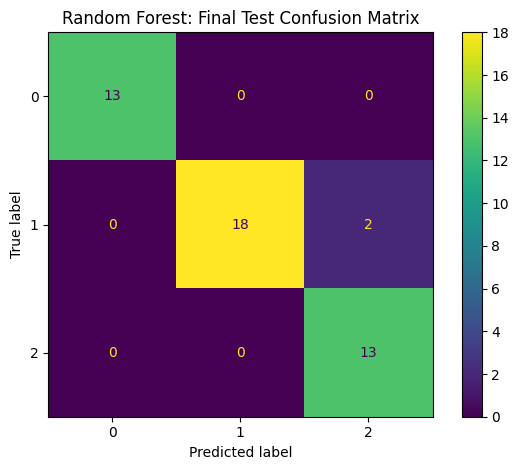

In [29]:
# Merge training and validation sets to maximize learning data.

X_final = np.vstack([X_train_pca, X_val_pca]);
y_final = np.hstack([y_train, y_val]);

# Retrains the tuned model on the full development set.
start = time.perf_counter()
best_rf.fit(X_final, y_final);
rf_train_time = time.perf_counter() - start


# Predicts classes for unseen test videos.

start = time.perf_counter();
rf_test_pred = best_rf.predict(X_test_pca_rf);
rf_test_time = time.perf_counter() - start;


# Reports final official performance.
print("Final RF Test Accuracy:", accuracy_score(y_test, rf_test_pred));
print(classification_report(y_test, rf_test_pred));


# Visualizes correct and incorrect predictions.
save_path = "../results/confusion_matrices/classical/rf_confusion_matrix.png";

disp = ConfusionMatrixDisplay.from_predictions(y_test, rf_test_pred);
plt.title("Random Forest: Final Test Confusion Matrix");
plt.tight_layout();
plt.savefig(save_path, dpi=300);
plt.show();
plt.close();

np.save("../results/stats_classical/rf_train_time.npy", rf_train_time);
np.save("../results/stats_classical/rf_test_time.npy", rf_test_time);

rf_acc = accuracy_score(y_test, rf_test_pred);
rf_f1  = f1_score(y_test, rf_test_pred, average="macro");

np.save("../results/stats_classical/rf_accuracy.npy", rf_acc);
np.save("../results/stats_classical/rf_f1.npy", rf_f1);

# Save RF-specific test features for comparative analysis (memory, efficiency etc.)
np.save("../results/stats_classical/X_test_rf.npy", X_test_pca_rf);


Random Forest: Error Analysis – Identify failure cases

In [30]:
# Find indices where the model prediction is wrong i.e., predicted label is not equal to true label.
wrong_idx = np.where(y_test != rf_test_pred)[0];

# Print total number of misclassified test samples
print("\nNumber of misclassified test videos:", len(wrong_idx));

# Display details of a few wrong predictions (first 5 only)
# This helps in manually inspecting failure cases
for i in wrong_idx[:5]:

    # Print the video file path
    print("Video:", test_videos[i]);

    # Print the true class label and the model's predicted label
    print("True Label:", y_test[i], "Predicted Label:", rf_test_pred[i]);

    # Print a separator line for better readability
    print("-" * 50);


Number of misclassified test videos: 2
Video: ../dataset_info/dataset\Punch/v_Punch_g13_c01.avi
True Label: 1 Predicted Label: 2
--------------------------------------------------
Video: ../dataset_info/dataset\Punch/v_Punch_g01_c04.avi
True Label: 1 Predicted Label: 2
--------------------------------------------------


Feature importance analysis

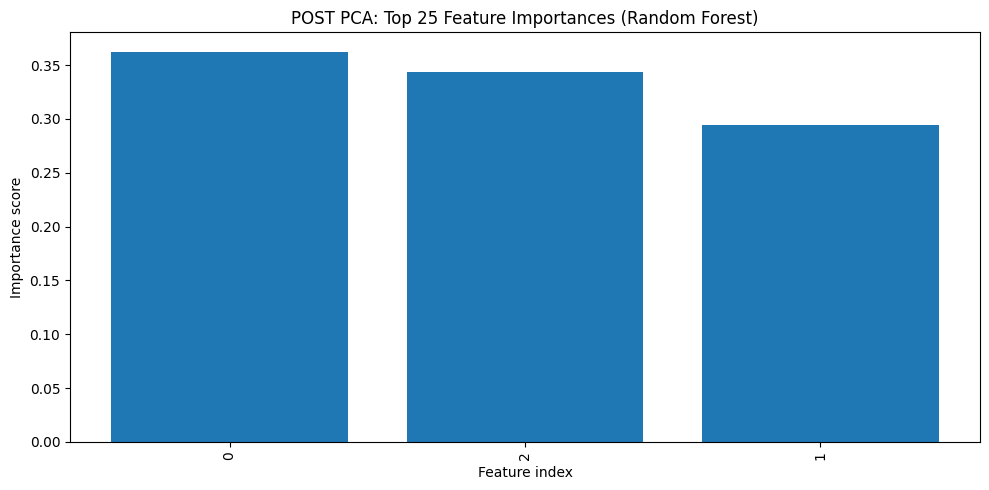

In [31]:
# Random Forest computes how important each feature was for splitting decisions.
# Higher value → more discriminative feature.
importances = best_rf.feature_importances_;

# Sorts features by importance and selects top 25 from the features we get after PCA.
indices = np.argsort(importances)[::-1][:25];

# Plots most influential features.
# This visually demonstrates:
    # which features contributed most
    # why ensemble learning works well

save_path = "../results/feature_visualizations/rf_top25_feature_importance.png";

plt.figure(figsize=(10,5));
plt.bar(range(len(indices)), importances[indices]);
plt.xticks(range(len(indices)), indices, rotation=90);
plt.title("POST PCA: Top 25 Feature Importances (Random Forest)");
plt.ylabel("Importance score");
plt.xlabel("Feature index");
plt.tight_layout();
plt.savefig(save_path, dpi=300);
plt.show();
plt.close();



3. k-Nearest Neighbors (k-NN)
- Distance metric comparison
- Optimal k value selection

In [32]:
# Baseline k-NN model
# This step builds a pipeline:
# Step 1 → StandardScaler()
# makes each feature zero-mean and unit-variance
    # Step 2 → KNeighborsClassifier(...)
# n_neighbors=5 → look at 5 nearest points
# metric="euclidean" → straight-line distance

knn_base = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10)),      # very strong compression
    ("knn", KNeighborsClassifier(
        n_neighbors=15,                 # large neighborhood
        weights="uniform",              # no distance bias
        metric="manhattan"               # weaker than euclidean here
    ))
])


# Stores all training feature vectors and their labels.
knn_base.fit(X_train, y_train);

# For each validation video:
# compute distance to all training videos
# find 5 nearest
# majority vote → predicted class

val_pred_knn = knn_base.predict(X_val);

# Evaluates baseline k-NN performance.
# This tells how well k=5 with Euclidean distance works.

print("Baseline kNN Validation Accuracy:", accuracy_score(y_val, val_pred_knn));
print(classification_report(y_val, val_pred_knn));


Baseline kNN Validation Accuracy: 0.6888888888888889
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.68      0.85      0.76        20
           2       0.67      0.31      0.42        13

    accuracy                           0.69        45
   macro avg       0.69      0.66      0.65        45
weighted avg       0.69      0.69      0.66        45



K-NN: Hyperparameter tuning

In [33]:
# Defines the search space:
    # different values of k
    # different distance metrics
    # This allows the system to find the best neighborhood size and distance definition.

param_grid = {
    "knn__n_neighbors": [11,15,21,25],
}

# Creates a grid search object.
    # build many k-NN models
    # test all parameter combinations
    # use 5-fold cross-validation
    # measure average accuracy
    # run in parallel

grid_knn = GridSearchCV(
    Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=10)),
        ("knn", KNeighborsClassifier(metric="manhattan"))
    ]),
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=4,
    verbose=2
)

grid_knn.fit(X_train, y_train);

# Shows:
    # optimal k
    #optimal distance metric
    # best cross-validated accuracy

print("Best kNN Parameters:", grid_knn.best_params_);
print("Best CV Accuracy:", grid_knn.best_score_);


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best kNN Parameters: {'knn__n_neighbors': 11}
Best CV Accuracy: 0.7490435490435491


Tuned k-NN on validation set

In [34]:
# Extracts the best tuned k-NN pipeline (Scaler + PCA + kNN);
best_knn = grid_knn.best_estimator_;

# Tests tuned k-NN on validation data.
val_pred_best = best_knn.predict(X_val);

# Checks whether tuning improved performance.
print("Tuned kNN Validation Accuracy:", accuracy_score(y_val, val_pred_best));
print(classification_report(y_val, val_pred_best));


Tuned kNN Validation Accuracy: 0.7111111111111111
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.69      0.90      0.78        20
           2       0.80      0.31      0.44        13

    accuracy                           0.71        45
   macro avg       0.74      0.68      0.67        45
weighted avg       0.73      0.71      0.68        45



k-NN: Final training and test evaluation

Final kNN Test Accuracy: 0.8478260869565217
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.90      0.90      0.90        20
           2       0.83      0.77      0.80        13

    accuracy                           0.85        46
   macro avg       0.84      0.84      0.84        46
weighted avg       0.85      0.85      0.85        46



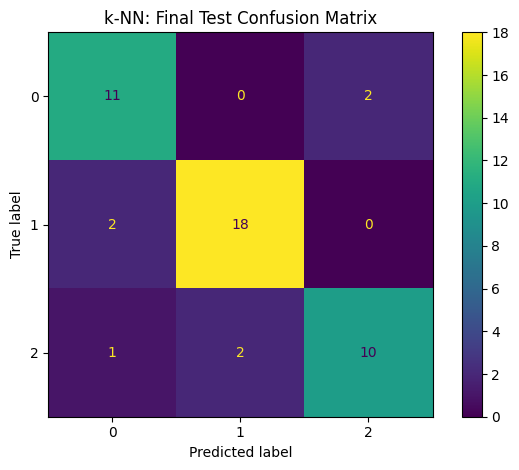

In [35]:
# Merges training and validation sets.
X_final = np.vstack([X_train, X_val]);
y_final = np.hstack([y_train, y_val]);

# Stores all final training feature vectors.
start = time.perf_counter();
best_knn.fit(X_final, y_final);
knn_train_time = time.perf_counter() - start;



# Predicts labels for unseen test videos.
start = time.perf_counter();
knn_test_pred = best_knn.predict(X_test);
knn_test_time = time.perf_counter() - start;

# Outputs official final results.
print("Final kNN Test Accuracy:", accuracy_score(y_test, knn_test_pred));
print(classification_report(y_test, knn_test_pred));


# Shows:
    # correct classifications (diagonal)
    # confusions between actions

os.makedirs("../results/confusion_matrices/classical", exist_ok=True);
save_path = "../results/confusion_matrices/classical/knn_confusion_matrix.png";

ConfusionMatrixDisplay.from_predictions(y_test, knn_test_pred);
plt.title("k-NN: Final Test Confusion Matrix");
plt.tight_layout();
plt.savefig(save_path, dpi=300);
plt.show();
plt.close();

np.save("../results/stats_classical/knn_train_time.npy", knn_train_time);
np.save("../results/stats_classical/knn_test_time.npy", knn_test_time);


# Saving performance metrics (for comparative analysis)
knn_acc = accuracy_score(y_test, knn_test_pred);
knn_f1  = f1_score(y_test, knn_test_pred, average="macro");

np.save("../results/stats_classical/knn_accuracy.npy", knn_acc);
np.save("../results/stats_classical/knn_f1.npy", knn_f1);


k-NN: Error Analysis – Identify failure cases

In [36]:
wrong_idx = np.where(y_test != knn_test_pred)[0];

print("\nNumber of misclassified test videos:", len(wrong_idx));
print("-" * 50);
for i in wrong_idx:
    print("Video:", test_videos[i]);
    print("True Label:", y_test[i], "Predicted Label:", knn_test_pred[i]);
    print("-" * 50);


Number of misclassified test videos: 7
--------------------------------------------------
Video: ../dataset_info/dataset\PullUps/v_PullUps_g07_c02.avi
True Label: 0 Predicted Label: 2
--------------------------------------------------
Video: ../dataset_info/dataset\PullUps/v_PullUps_g07_c04.avi
True Label: 0 Predicted Label: 2
--------------------------------------------------
Video: ../dataset_info/dataset\Punch/v_Punch_g13_c06.avi
True Label: 1 Predicted Label: 0
--------------------------------------------------
Video: ../dataset_info/dataset\Punch/v_Punch_g01_c04.avi
True Label: 1 Predicted Label: 0
--------------------------------------------------
Video: ../dataset_info/dataset\PushUps/v_PushUps_g18_c03.avi
True Label: 2 Predicted Label: 0
--------------------------------------------------
Video: ../dataset_info/dataset\PushUps/v_PushUps_g15_c03.avi
True Label: 2 Predicted Label: 1
--------------------------------------------------
Video: ../dataset_info/dataset\PushUps/v_PushUp

4. Logistic Regression
- L1/L2 regularization
- Multi-class classification

In [37]:
# This creates a three-stage machine learning pipeline:
# StandardScaler()
    # Scales all features to the same range.
    # Prevents features with large values from dominating training.

# PCA(n_components=50)
    # Reduces thousands of handcrafted features into 50 most informative components.
    # Removes noise, correlation, and reduces overfitting.

# LogisticRegression(...)
    # C=0.005 → strong regularization (keeps model simple, avoids memorization).
    # solver="lbfgs" → fast optimizer for multiclass problems.
    # max_iter=2000 → ensures proper convergence.

# This pipeline ensures:
    # normalization → dimensionality reduction → classification.

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=8, random_state=42)),
    ("logreg", LogisticRegression(
        C=0.001,
        solver="lbfgs",
        max_iter=2000
    ))
]);


# -------- Train on TRAIN, evaluate on VAL --------
#The pipeline learns:
    # scaling parameters
    # PCA directions
    # logistic regression weights from the training data only.

logreg.fit(X_train, y_train);

# Uses the trained model to predict labels of validation videos.
# Validation data is unseen during training.

val_pred = logreg.predict(X_val);

# accuracy_score → overall correctness.
# classification_report → shows precision, recall, and F1-score for each action class.
# Helps judge whether the model generalizes well.

print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, val_pred));
print(classification_report(y_val, val_pred));


# -------- Final training (TRAIN + VAL) --------
# Combines training and validation data.
# Gives the final model more samples to learn from before final testing.

X_final = np.vstack([X_train, X_val]);
y_final = np.hstack([y_train, y_val]);

# Retrains the model using all available labeled data (except test set).
# Produces the strongest possible final classifier.
start = time.perf_counter();
logreg.fit(X_final, y_final);
logreg_train_time = time.perf_counter() - start;


Logistic Regression Validation Accuracy: 0.7333333333333333
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.76      0.80      0.78        20
           2       0.67      0.46      0.55        13

    accuracy                           0.73        45
   macro avg       0.72      0.73      0.71        45
weighted avg       0.73      0.73      0.72        45



Logistic Regression: Final TEST evaluation

Final Logistic Regression Test Accuracy: 0.6956521739130435
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.76      0.80      0.78        20
           2       0.54      0.54      0.54        13

    accuracy                           0.70        46
   macro avg       0.68      0.68      0.68        46
weighted avg       0.70      0.70      0.69        46



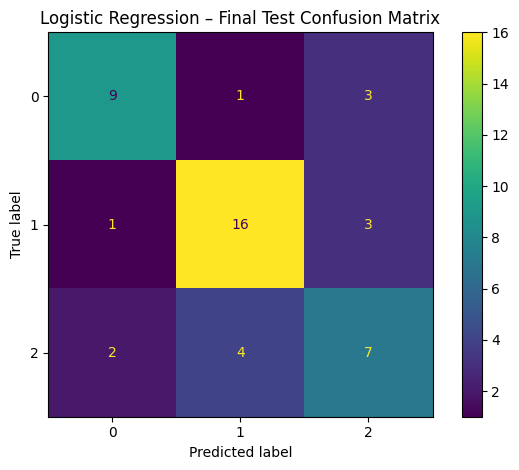

In [38]:

# Predicts actions of completely unseen test videos.
# This represents the true performance of the model.
start = time.perf_counter();
logreg_test_pred = logreg.predict(X_test);
logreg_test_time = time.perf_counter() - start

# Measures how well the final model generalizes.
# These are the results you report.

print("Final Logistic Regression Test Accuracy:", accuracy_score(y_test, logreg_test_pred));
print(classification_report(y_test, logreg_test_pred));

# Displays how many samples were correctly or incorrectly classified.
# Helps analyze which actions are confused with each other.

save_path = "../results/confusion_matrices/classical/logreg_confusion_matrix.png"

ConfusionMatrixDisplay.from_predictions(y_test, logreg_test_pred);
plt.title("Logistic Regression – Final Test Confusion Matrix");
plt.tight_layout();
plt.savefig(save_path, dpi=300);
plt.show();
plt.close();


np.save("../results/stats_classical/logreg_train_time.npy", logreg_train_time);
np.save("../results/stats_classical/logreg_test_time.npy", logreg_test_time);

# Saving performance metrics (for comparative analysis)
logreg_acc = accuracy_score(y_test, logreg_test_pred);
logreg_f1  = f1_score(y_test, logreg_test_pred, average="macro");

np.save("../results/stats_classical/logreg_accuracy.npy", logreg_acc);
np.save("../results/stats_classical/logreg_f1.npy", logreg_f1);


Logistic Regression: Error Analysis – Identify failure cases

In [39]:

wrong_idx = np.where(y_test != logreg_test_pred)[0];

print("\nNumber of misclassified test videos:", len(wrong_idx));

for i in wrong_idx:
    print("Video:", test_videos[i]);
    print("True Label:", y_test[i], "Predicted Label:", logreg_test_pred[i]);
    print("-" * 50);


Number of misclassified test videos: 14
Video: ../dataset_info/dataset\PullUps/v_PullUps_g14_c03.avi
True Label: 0 Predicted Label: 2
--------------------------------------------------
Video: ../dataset_info/dataset\PullUps/v_PullUps_g09_c01.avi
True Label: 0 Predicted Label: 1
--------------------------------------------------
Video: ../dataset_info/dataset\PullUps/v_PullUps_g07_c02.avi
True Label: 0 Predicted Label: 2
--------------------------------------------------
Video: ../dataset_info/dataset\PullUps/v_PullUps_g07_c04.avi
True Label: 0 Predicted Label: 2
--------------------------------------------------
Video: ../dataset_info/dataset\Punch/v_Punch_g08_c07.avi
True Label: 1 Predicted Label: 2
--------------------------------------------------
Video: ../dataset_info/dataset\Punch/v_Punch_g10_c02.avi
True Label: 1 Predicted Label: 0
--------------------------------------------------
Video: ../dataset_info/dataset\Punch/v_Punch_g16_c03.avi
True Label: 1 Predicted Label: 2
-------

5. Gradient Boosting (XGBoost or LightGBM)
- Tree-based ensemble learning
- Feature importance ranking


Train Gradient Boosting on TRAIN set

In [40]:
gb = GradientBoostingClassifier(

    # Number of boosting stages (trees).
    # Fewer trees reduce model complexity and overfitting.
    n_estimators=80,

    # Shrinks the contribution of each tree.
    # Smaller values make learning slower but more stable
    # and improve generalization.
    learning_rate=0.05,

    # Maximum depth of each individual decision tree.
    # Shallow trees act as weak learners and prevent memorization.
    max_depth=2,

    # Fraction of training samples used to fit each tree.
    # Using less than 100% introduces randomness and acts as
    # regularization (stochastic gradient boosting).
    subsample=0.8,

    # Fixes random behavior for reproducibility.
    random_state=42
);

gb.fit(X_train, y_train);


Gradient Boosting: Validation performance

In [41]:
val_pred_gb = gb.predict(X_val);

print("Gradient Boosting Validation Accuracy:", accuracy_score(y_val, val_pred_gb));
print(classification_report(y_val, val_pred_gb));


Gradient Boosting Validation Accuracy: 0.9111111111111111
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.90      0.95      0.93        20
           2       0.92      0.85      0.88        13

    accuracy                           0.91        45
   macro avg       0.91      0.90      0.91        45
weighted avg       0.91      0.91      0.91        45



Gradient Boosting: Final training (TRAIN + VAL)

In [42]:
X_final = np.vstack([X_train, X_val]);
y_final = np.hstack([y_train, y_val]);

start = time.perf_counter();
gb.fit(X_final, y_final);
gb_train_time = time.perf_counter() - start;

Gradient Boosting: Final TEST evaluation

Final Gradient Boosting Test Accuracy: 0.9782608695652174
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00        13

    accuracy                           0.98        46
   macro avg       0.98      0.97      0.98        46
weighted avg       0.98      0.98      0.98        46



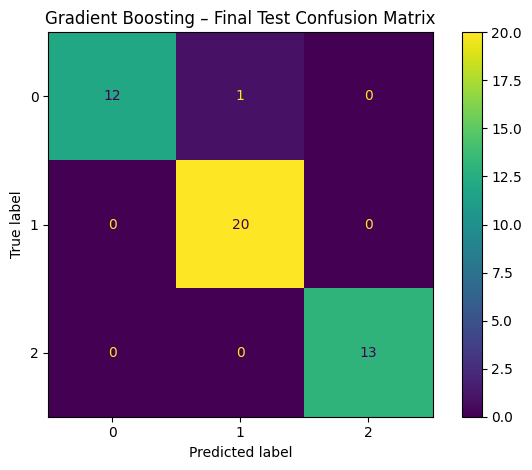

In [43]:
start = time.perf_counter();
gb_test_pred = gb.predict(X_test);
gb_test_time = time.perf_counter() - start;
print("Final Gradient Boosting Test Accuracy:", accuracy_score(y_test, gb_test_pred));
print(classification_report(y_test, gb_test_pred));

save_path = "../results/confusion_matrices/classical/gb_confusion_matrix.png";

ConfusionMatrixDisplay.from_predictions(y_test, gb_test_pred);
plt.title("Gradient Boosting – Final Test Confusion Matrix");
plt.tight_layout();
plt.savefig(save_path, dpi=300);
plt.show();
plt.close();


np.save("../results/stats_classical/gb_train_time.npy", gb_train_time);
np.save("../results/stats_classical/gb_test_time.npy", gb_test_time);

gb_acc = accuracy_score(y_test, gb_test_pred);
gb_f1  = f1_score(y_test, gb_test_pred, average="macro");

np.save("../results/stats_classical/gb_accuracy.npy", gb_acc);
np.save("../results/stats_classical/gb_f1.npy", gb_f1);


Gradient Boosting: Error Analysis – Identify failure cases

In [44]:

wrong_idx = np.where(y_test != gb_test_pred)[0]

print("\nNumber of misclassified test videos:", len(wrong_idx))

for i in wrong_idx[:5]:
    print("Video:", test_videos[i])
    print("True Label:", y_test[i], "Predicted Label:", gb_test_pred[i])
    print("-" * 50)



Number of misclassified test videos: 1
Video: ../dataset_info/dataset\PullUps/v_PullUps_g09_c01.avi
True Label: 0 Predicted Label: 1
--------------------------------------------------


Gradient Boosting: Feature importance ranking

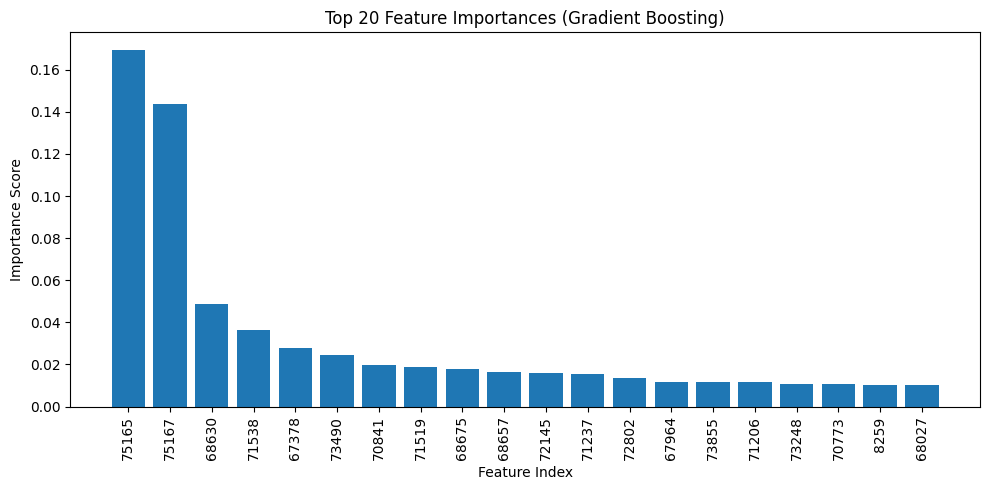

In [45]:
importances = gb.feature_importances_;

# Top 20 important features
indices = np.argsort(importances)[-20:][::-1];
plt.figure(figsize=(10,5));
plt.bar(range(20), importances[indices]);
plt.xticks(range(20), indices, rotation=90);
plt.title("Top 20 Feature Importances (Gradient Boosting)");
plt.xlabel("Feature Index");
plt.ylabel("Importance Score");
plt.tight_layout();
plt.savefig("../results/feature_visualizations/gb_top20_feature_importance.png", dpi=300);
plt.show();
plt.close();


At this stage, following Classical Machine Learning models have been implemented:
1. Support Vector Machine (SVM)
2. Random Forest
3. k Nearest Neighbor (k-NN)
4. Logistic Regression
5. Gradient Boosting

Next step:

### Saving the final results of all the implemented models:

In [46]:
np.save("../results/final_classical_X_test.npy", X_test);
np.save("../results/final_classical_y_test.npy", y_test);

np.save("../results/stats_classical/svm_test_pred.npy", svm_test_pred);
np.save("../results/stats_classical/rf_test_pred.npy", rf_test_pred);
np.save("../results/stats_classical/knn_test_pred.npy", knn_test_pred);
np.save("../results/stats_classical/logreg_test_pred.npy", logreg_test_pred);
np.save("../results/stats_classical/gb_test_pred.npy", gb_test_pred);


Saving the trained models on disk:

In [47]:
print("Saving trained SVM:", joblib.dump(best_svm, "../results/saved_models/classical/svm_trained_model.joblib"));
print("Saving trained Random Forest:",joblib.dump(best_rf, "../results/saved_models/classical/rf_trained_model.joblib"));
print("Saving trained KNN:", joblib.dump(best_knn, "../results/saved_models/classical/knn_trained_model.joblib"));
print("Saving trained Logistic Regression:",joblib.dump(logreg, "../results/saved_models/classical/logreg_trained_model.joblib"));
print("Saving trained Gradient Boosting:",joblib.dump(gb, "../results/saved_models/classical/gb_trained_model.joblib"));


Saving trained SVM: ['../results/saved_models/classical/svm_trained_model.joblib']
Saving trained Random Forest: ['../results/saved_models/classical/rf_trained_model.joblib']
Saving trained KNN: ['../results/saved_models/classical/knn_trained_model.joblib']
Saving trained Logistic Regression: ['../results/saved_models/classical/logreg_trained_model.joblib']
Saving trained Gradient Boosting: ['../results/saved_models/classical/gb_trained_model.joblib']
